In [207]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


In [208]:
# Read input data from file
data = np.loadtxt('../HRMAnalysisCPP/input_data.txt')
print(data)

[[0.0000e+00 4.0902e+04]
 [2.0000e+01 4.0906e+04]
 [4.0000e+01 4.0908e+04]
 ...
 [4.5850e+04 4.0379e+04]
 [4.5870e+04 4.0384e+04]
 [4.5890e+04 4.0394e+04]]


In [209]:
# rng = np.random.default_rng()
# t = np.linspace(-1, 1, 201)
# x = (np.sin(2*np.pi*0.75*t*(1-t) + 2.1) +
#      0.1*np.sin(2*np.pi*1.25*t + 1) +
#      0.18*np.cos(2*np.pi*3.85*t))
# xn = x + rng.standard_normal(len(t)) * 0.08
t = data[:, 0]
xn = data[:, 1]

In [210]:
b, a = signal.butter(2, 1.25, fs=50, btype='low')
print(f"b: {b} a: {a}")

b: [0.00554272 0.01108543 0.00554272] a: [ 1.         -1.77863178  0.80080265]


In [211]:
zi = signal.lfilter_zi(b, a)
# print(zi)
# # zi[0] = 0
# # zi[1] = 0
# z, _ = signal.lfilter(b, a, xn, zi=zi*xn[0])
# # z = signal.lfilter(b, a, xn)

In [212]:
class IIRFilter:
    def __init__(self, b, a, zi):
        self.b = b
        self.a = a
        self.zi = zi
        self.v1m1 = 0
        self.v2m1 = 0
        self.v1m = 0
        self.v2m = 0
        self.doneFirst = False
        self.count = 0

    def filter_one_point(self, x1):
        if not self.doneFirst:
            self.v1m1 = x1 * self.zi[0]
            self.v2m1 = x1 * self.zi[1]
            self.doneFirst = True
        y1 = (self.b[0] * x1 + self.v1m1) / self.a[0]
        self.v1m = (self.b[1] * x1 + self.v2m1) - self.a[1] * y1
        self.v2m = self.b[2] * x1 - self.a[2] * y1
        if self.count < 100:
            # printf("BPF: %f %f %f %f %f %f %f %f %f\n", x1, y1, v1m1, v2m1, v1m, v2m, b[0], b[1], b[2]);
            # print(f"i: {self.count} x1: {x1} y1: {y1} v1m1: {self.v1m1} v2m1: {self.v2m1} v1m: {self.v1m} v2m: {self.v2m} b[0]: {self.b[0]} b[1]: {self.b[1]} b[2]: {self.b[2]} a[0]: {self.a[0]} a[1]: {self.a[1]} a[2]: {self.a[2]} zi[0]: {self.zi[0]} zi[1]: {self.zi[1]}")
            self.count += 1
        self.v1m1 = self.v1m
        self.v2m1 = self.v2m
        return y1

In [213]:
iirFilter = IIRFilter(b, a, zi)
z = [iirFilter.filter_one_point(x) for x in xn]

In [214]:
bhigh, ahigh = signal.butter(2, 0.75, fs=50, btype='high')
zihigh = signal.lfilter_zi(bhigh, ahigh)
print(f"bhigh: {bhigh} ahigh: {ahigh} zihigh: {zihigh}")
iirFilterHigh = IIRFilter(bhigh, ahigh, zihigh)
zhigh = [iirFilterHigh.filter_one_point(x) for x in z]

bhigh: [ 0.93552671 -1.87105341  0.93552671] ahigh: [ 1.         -1.86689228  0.87521455] zihigh: [-0.93552671  0.93552671]


In [215]:
z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])

In [216]:
y = signal.filtfilt(b, a, xn)

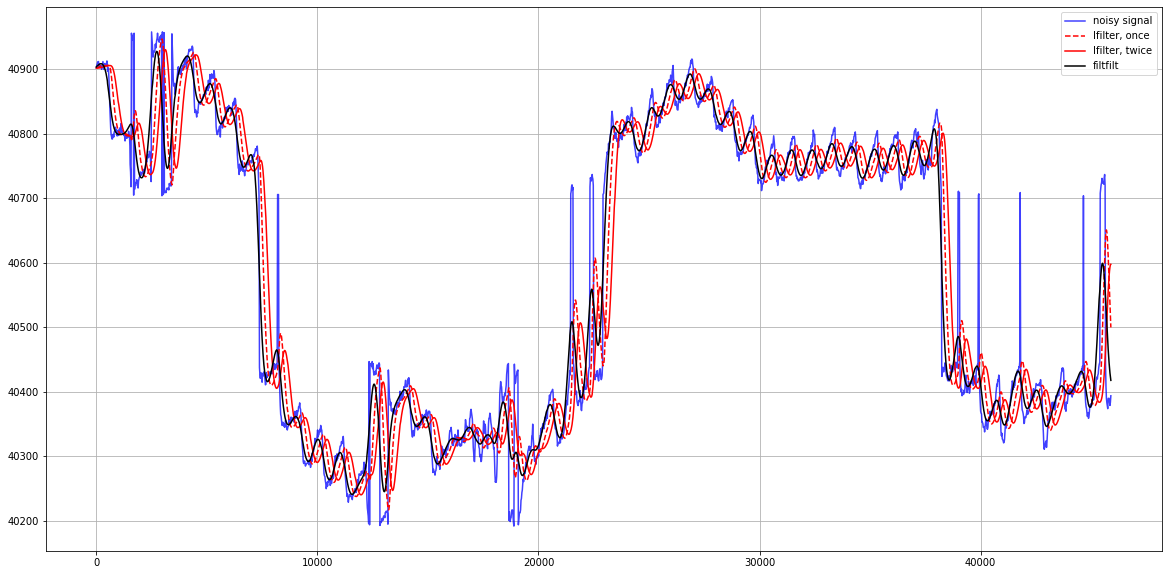

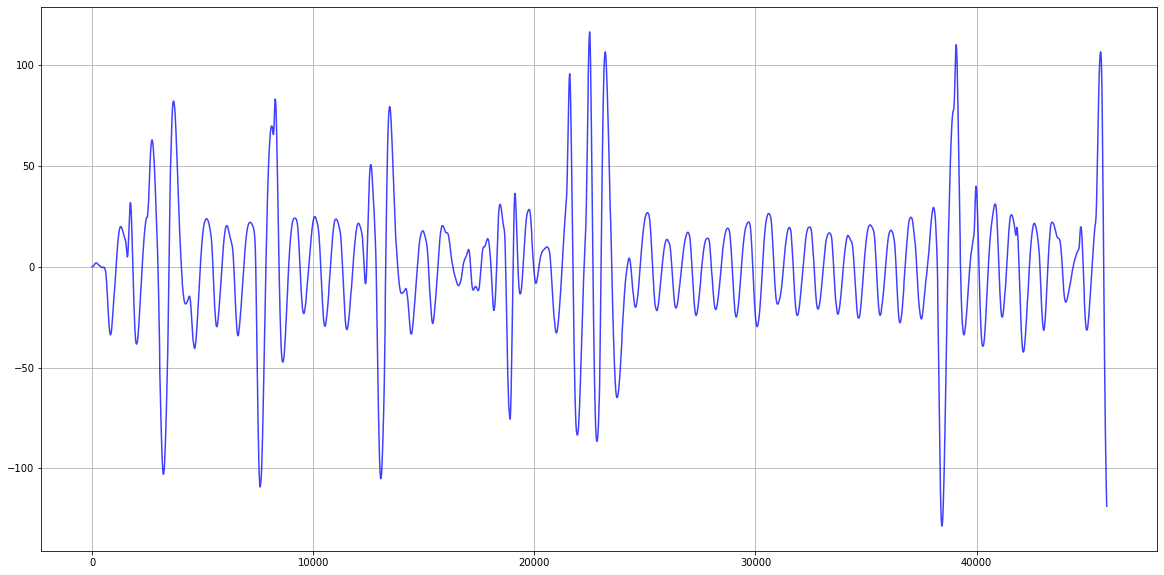

In [217]:
# Set plot size
plt.rcParams["figure.figsize"] = (20, 10)

plt.figure
plt.plot(t, xn, 'b', alpha=0.75)
plt.plot(t, z, 'r--', t, z2, 'r', t, y, 'k')
plt.legend(('noisy signal', 'lfilter, once', 'lfilter, twice',
            'filtfilt'), loc='best')
plt.grid(True)
plt.show()

# Plot zhigh
plt.figure
plt.plot(t, zhigh, 'b', alpha=0.75)
plt.grid(True)
plt.show()
